In [23]:
import torch
import os
import h5py
import preprocess
import numpy as np
import matplotlib.pyplot as plt
from utils import SequenceDataset, plot_sample
from tqdm import tqdm
from torch.utils.data import DataLoader
from torch import nn, optim
from pathlib import Path
# Import the necessary classes
from score import ScoreUNet
from score import VPSDE
import importlib

In [24]:
checkpoint_path = "slurm/checkpoints/attention_config_spatial_T2m_U10m_2000_2014/attention_config_spatial_T2m_U10m_2000_2014_120.pth"

In [25]:
import importlib
import score
importlib.reload(score)
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

PATH_DATA = Path('./data/processed')
# Load mask
with h5py.File(PATH_DATA / "mask.h5", "r") as f:
    mask = torch.tensor(f["dataset"][:], dtype=torch.float32, device=device).unsqueeze(0)
    mask_cpu = mask.detach().clone().cpu()
if torch.isnan(mask).any():
    raise ValueError("Mask contains NaN values!")
window = 12
# Load dataset to get dimensions
testset = SequenceDataset(PATH_DATA / "test.h5", window=window, flatten=True)

channels, y_dim, x_dim = testset[0][0].shape
print(f"Channels : {channels}")

TRAIN_CONFIG = {
    "epochs": 10000,
    "batch_size": 48,
    "learning_rate": 2e-4,
    "weight_decay": 1e-4,
    "scheduler": "cosine",
    "embedding": 64,
    "activation": "SiLU",
    "eta": 5e-3,
}
MODEL_CONFIG = { 'hidden_channels' : [64, 128,128,256],
'attention_levels' : [2],
'hidden_blocks' : [2,3,3,3],
'spatial' : 2,
'channels' : channels,
'context' : 4,
'embedding' : 64 }


Using device: cuda
Spatial Encoding Shape : torch.Size([4, 64, 64])
Channels : 24


In [26]:
batch_size = TRAIN_CONFIG['batch_size']
testloader = DataLoader(testset, batch_size=batch_size, shuffle=True, num_workers=1, persistent_workers=True)
# Initialize ScoreUNet and VPSDE
score_unet = ScoreUNet(**MODEL_CONFIG).to(device)
vpsde = VPSDE(score_unet, shape=(channels, y_dim, x_dim), eta = TRAIN_CONFIG["eta"]).to(device)
# Load checkpoint
checkpoint = torch.load(checkpoint_path, map_location=device)
vpsde.load_state_dict(checkpoint['model_state_dict'])
print(f"Model restored from {checkpoint_path}, trained until epoch {checkpoint['epoch']}")

/tmp/ipykernel_2010247/3784321478.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location=device)


Model restored from slurm/checkpoints/attention_config_spatial_T2m_U10m_2000_2014/attention_config_spatial_T2m_U10m_2000_2014_120.pth, trained until epoch 120


In [27]:
for batch, dic in testloader:
    t = torch.rand(batch.shape[0], dtype=batch.dtype)
    t[0] = 0.8
    t[1] = 0.9
    t[2] = 1
    c = dic["context"]
    c = c.to(device)
    batch = batch.to(device)
    t = t.to(device)
    x_t = vpsde.forward(batch, t , train=False)
    x_0 = vpsde.denoise(x_t,t,c)
    print(vpsde.mu(t[:3]))
    print(vpsde.sigma(t[:3]))
    break

tensor([0.1313, 0.0480, 0.0050], device='cuda:0')
tensor([0.9914, 0.9989, 1.0000], device='cuda:0')


<h1> Display Batch </h1>

torch.Size([48, 24, 64, 64])
torch.Size([48, 2, 12, 64, 64])
torch.Size([48, 2, 12, 64, 64])
Input shape: torch.Size([48, 2, 12, 64, 64])
T2m  Mean : 14.194117546081543, Var: 1.6830315589904785
U10m  Mean : 3.3620364665985107, Var: 1.0995943546295166
T2m  Mean : 15.747247695922852, Var: 2.3742382526397705
U10m  Mean : 2.3394689559936523, Var: 0.7835365533828735
T2m  Mean : 16.523847579956055, Var: 1.712723731994629
U10m  Mean : 3.149155378341675, Var: 1.1568169593811035
T2m  Mean : -0.07658618688583374, Var: 1.1869075298309326
U10m  Mean : 2.8962578773498535, Var: 1.0193016529083252
T2m  Mean : 18.265342712402344, Var: 3.116888999938965
U10m  Mean : 5.640145301818848, Var: 1.8586407899856567


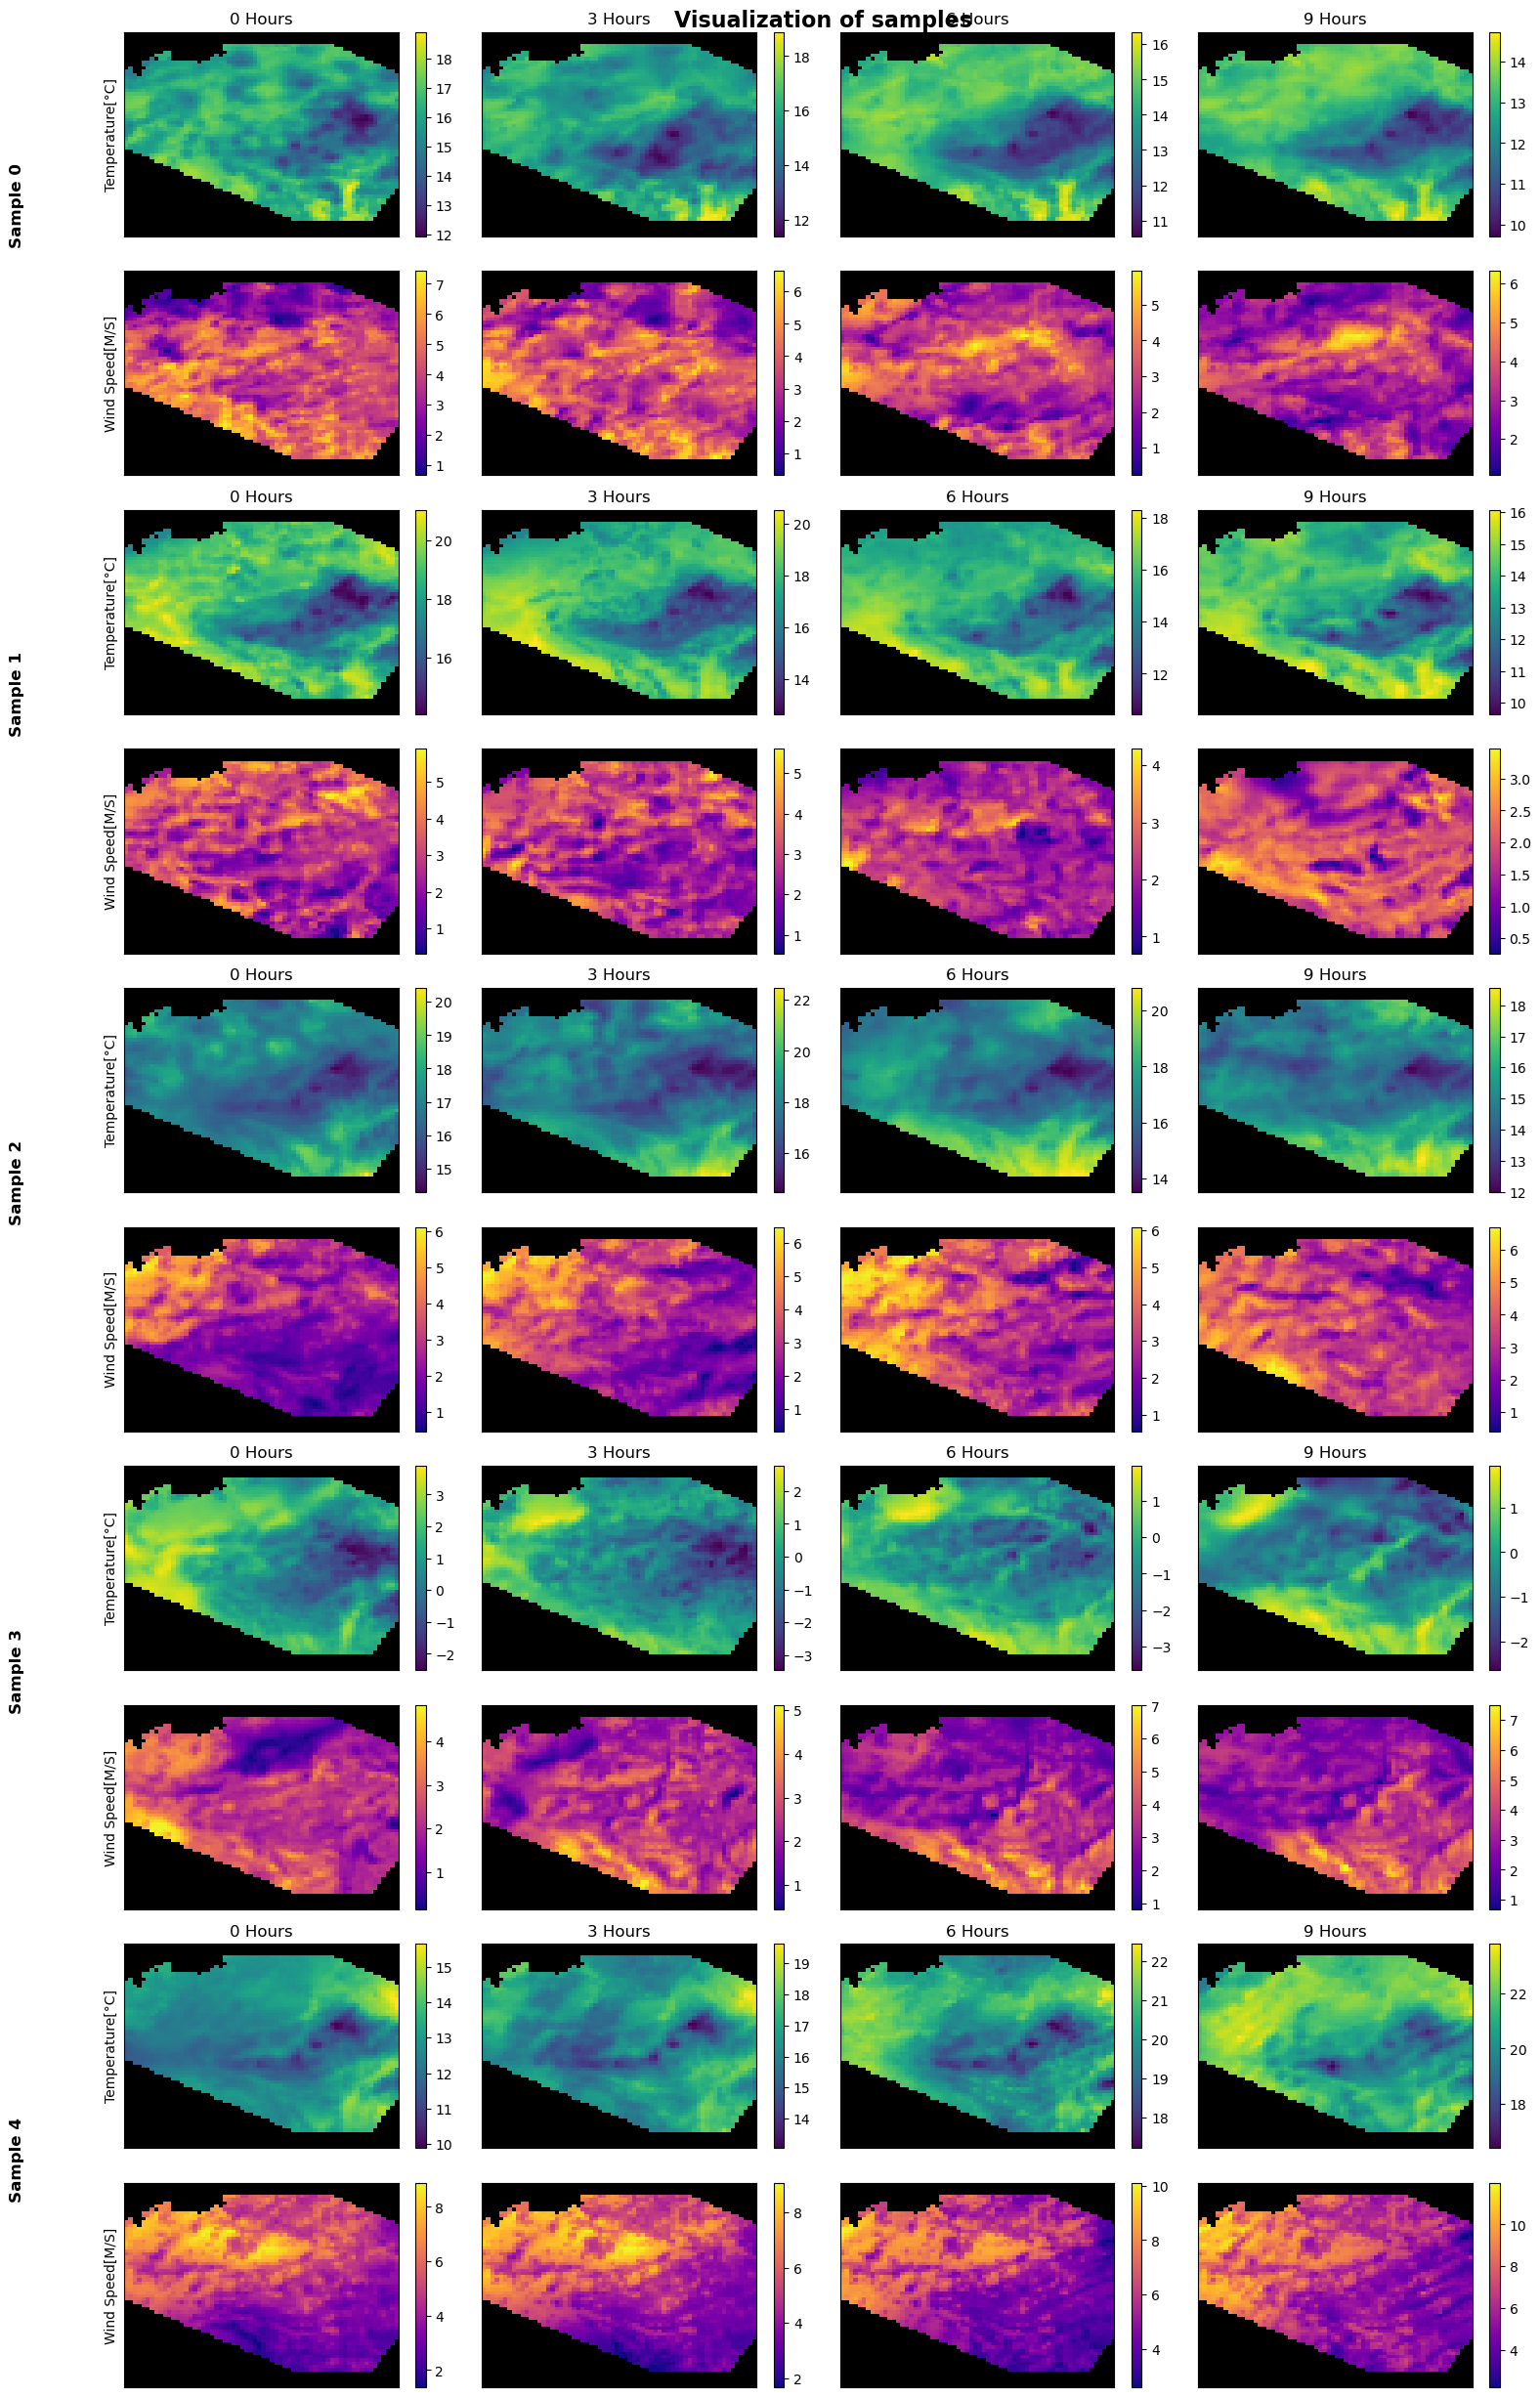

In [28]:
from utils import plot_sample
path_unnorm = PATH / "data/processed/train.h5"
info = {'var_index': ['T2m', 'U10m'], 'channels': 2, 'window': 12}

batch_cpu = batch.detach().cpu()
fig = plot_sample(batch_cpu, info, mask_cpu, samples=5, step=3, unnormalize=True, path_unnorm = path_unnorm)

<h1> Load and Plot Samples</h1>

In [48]:
# Load Samples
c = c.to(torch.float32).to(device)

sample = vpsde.sample(mask,c=c[:10],shape=(10,),steps=128, corrections=0)

100%|█████████████████████████████████████████████████| 128/128 [00:02<00:00, 56.85it/s]


torch.Size([10, 24, 64, 64])
torch.Size([10, 2, 12, 64, 64])
torch.Size([10, 2, 12, 64, 64])
Input shape: torch.Size([10, 2, 12, 64, 64])
T2m  Mean : 19.07151985168457, Var: 3.477357864379883
U10m  Mean : 3.310786247253418, Var: 1.2706962823867798
T2m  Mean : 12.932326316833496, Var: 3.3067305088043213
U10m  Mean : 2.3899500370025635, Var: 1.3052191734313965
T2m  Mean : 16.71734619140625, Var: 4.323033809661865
U10m  Mean : 3.1054656505584717, Var: 2.302677631378174
T2m  Mean : 17.46998405456543, Var: 3.7721059322357178
U10m  Mean : 5.656887054443359, Var: 2.081277847290039
T2m  Mean : 16.152694702148438, Var: 4.601285457611084
U10m  Mean : 4.2882843017578125, Var: 4.124392986297607
T2m  Mean : 8.992790222167969, Var: 3.2790029048919678
U10m  Mean : 1.6381257772445679, Var: 1.1091092824935913
T2m  Mean : 24.001073837280273, Var: 3.7304861545562744
U10m  Mean : 1.8624931573867798, Var: 1.5954205989837646
T2m  Mean : 10.662169456481934, Var: 3.178013801574707
U10m  Mean : 2.0970616340637

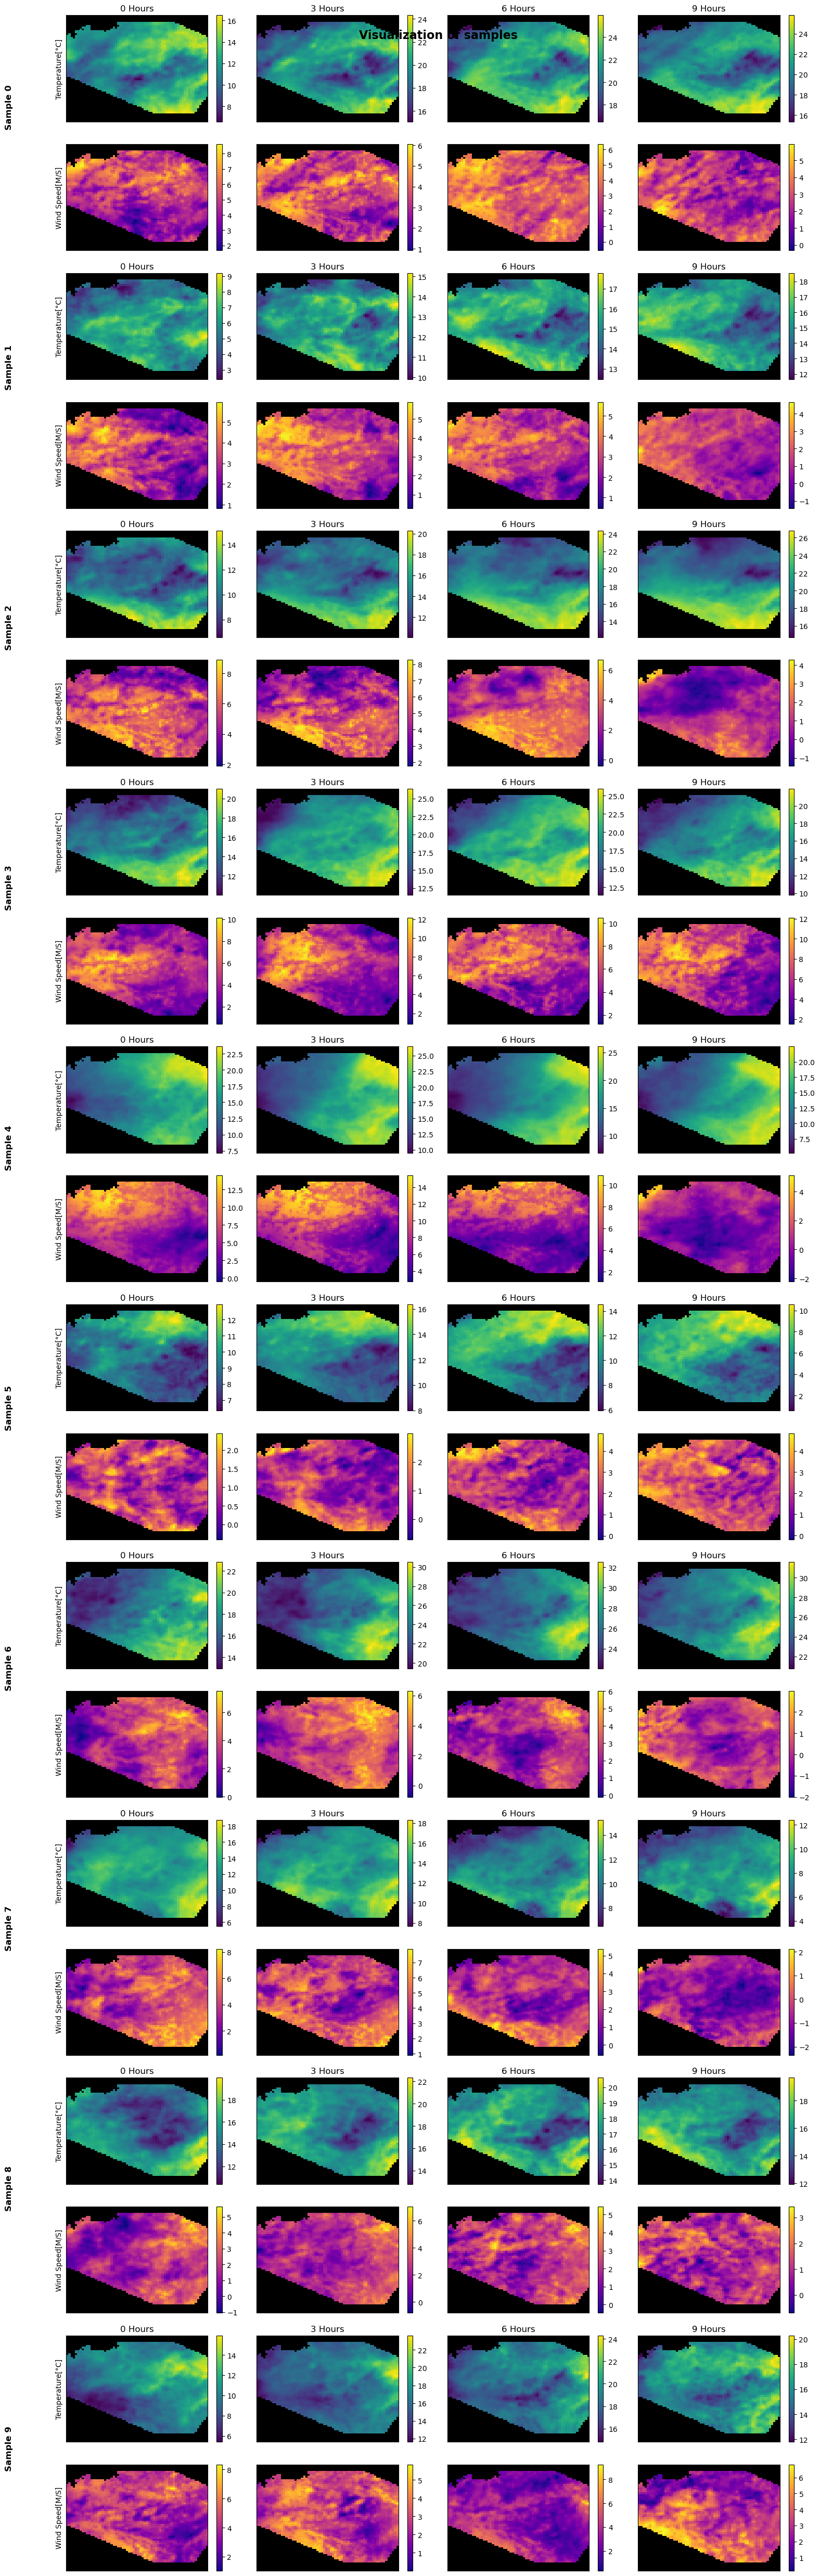

In [49]:
sample_cpu = sample.detach().cpu()
info  = {'var_index': ['T2m', 'U10m'], 'channels' : 2, 'window' : 12}
fig = plot_sample(sample_cpu,info,mask_cpu,samples=10,step=3, unnormalize=True, path_unnorm = path_unnorm)

<h1>Plot : Batch, Noised Batch and Unnoising of Noised Batch</h1>

torch.Size([144, 24, 64, 64])
torch.Size([144, 2, 12, 64, 64])
torch.Size([144, 2, 12, 64, 64])
Input shape: torch.Size([144, 2, 12, 64, 64])
T2m  Mean : 8.846041679382324, Var: 2.149075508117676
U10m  Mean : 2.4688844680786133, Var: 0.6711364388465881
T2m  Mean : 11.080101013183594, Var: 7.360535621643066
U10m  Mean : 3.8406333923339844, Var: 2.1638216972351074
T2m  Mean : 9.218770027160645, Var: 2.712505578994751
U10m  Mean : 2.4681200981140137, Var: 0.6817473769187927
T2m  Mean : 26.903682708740234, Var: 3.9482598304748535
U10m  Mean : 3.969309091567993, Var: 1.1825406551361084
T2m  Mean : 12.07194709777832, Var: 7.2771501541137695
U10m  Mean : 4.0369791984558105, Var: 2.1688075065612793
T2m  Mean : 25.695274353027344, Var: 4.797074317932129
U10m  Mean : 3.7090768814086914, Var: 1.5256965160369873
T2m  Mean : 3.6903765201568604, Var: 1.6928553581237793
U10m  Mean : 8.408134460449219, Var: 2.3721511363983154
T2m  Mean : 11.352189064025879, Var: 7.30765962600708
U10m  Mean : 4.0661902

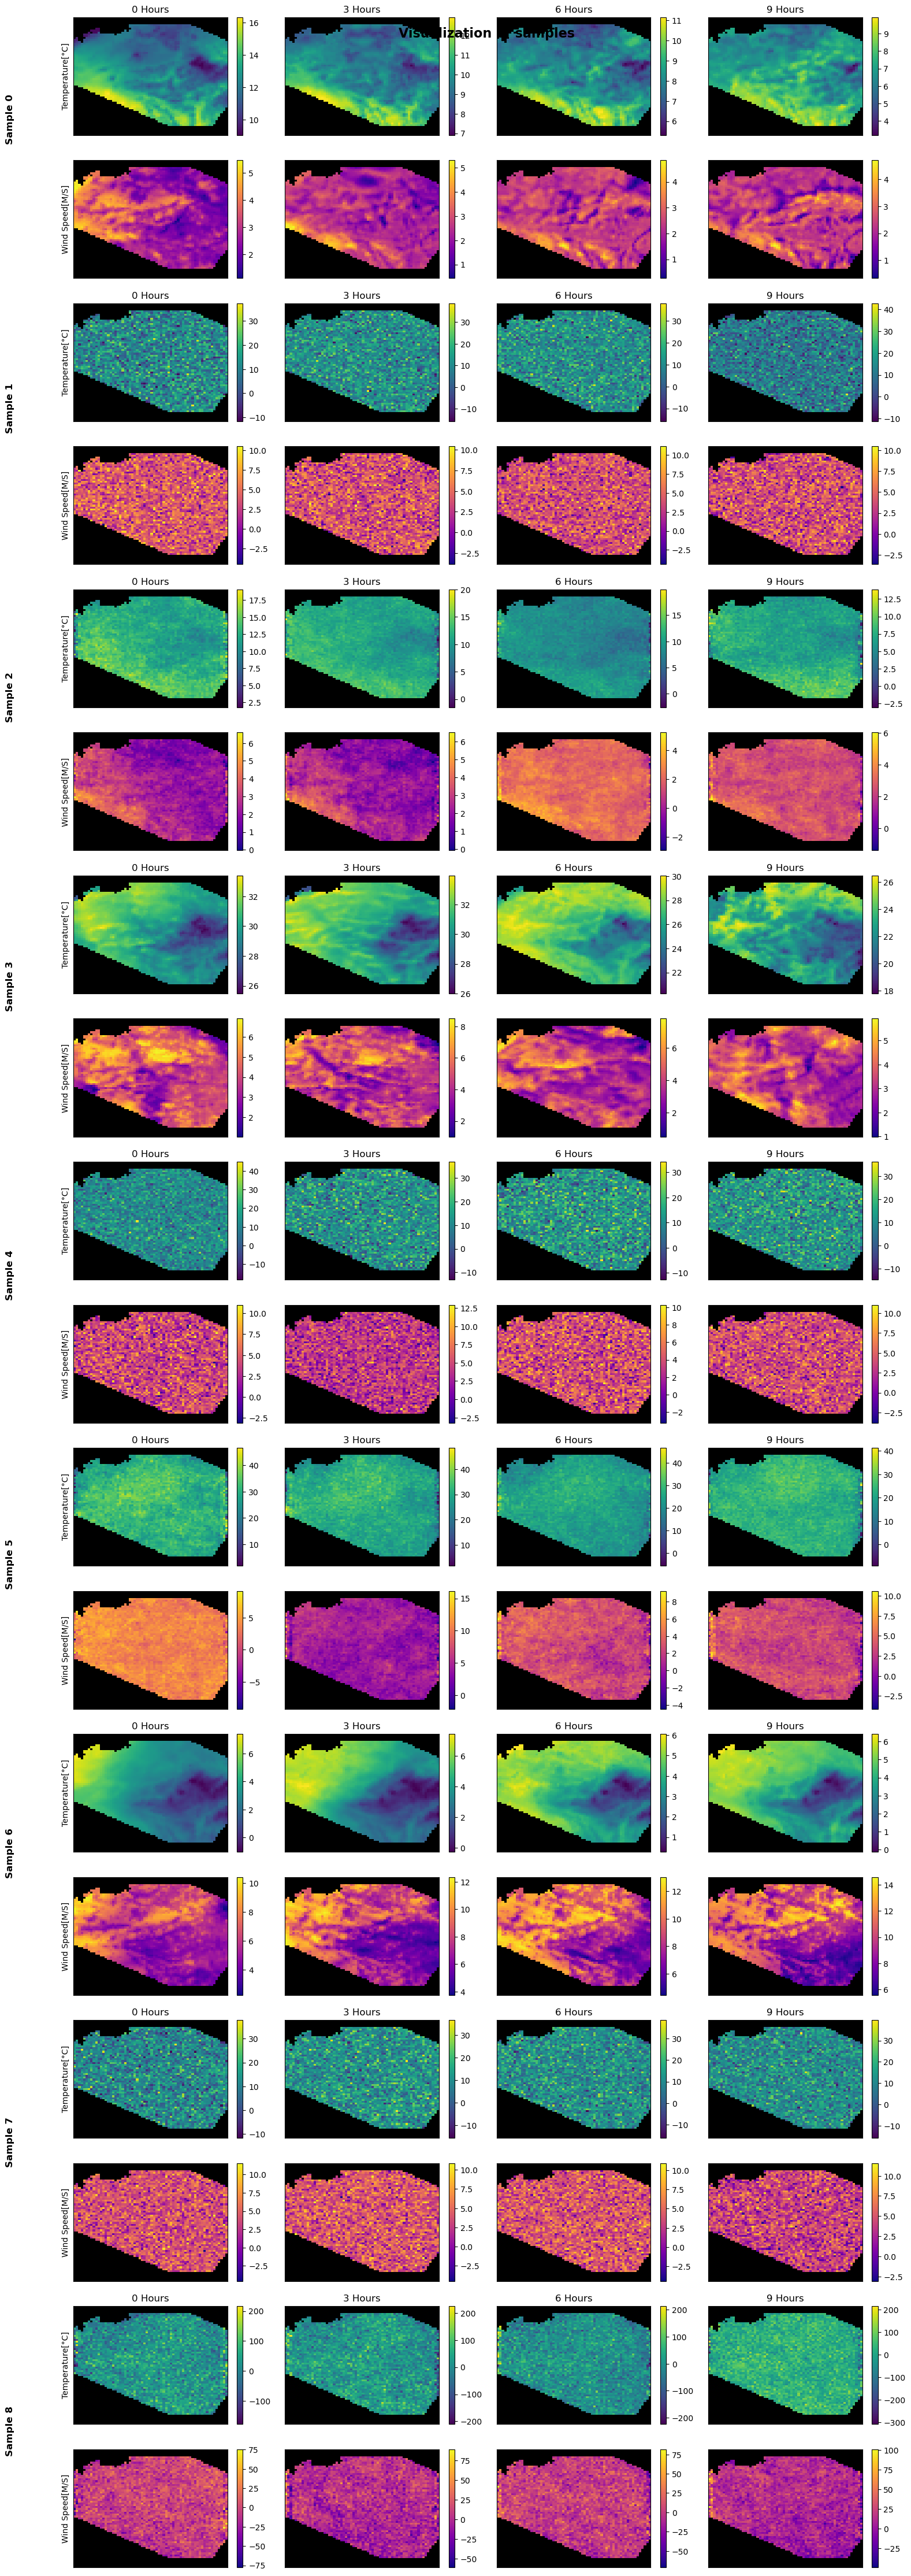

In [22]:
info  = {'var_index': ['T2m', 'U10m'], 'channels' : 2, 'window' : 12}
new_tensor = torch.stack((batch,x_t,x_0), dim=1).flatten(0,1).detach().cpu()

fig = plot_sample(new_tensor,info,mask_cpu,samples=9,step=3, unnormalize=True)